### Contradictory, My Dear Watson
- this notebook was created as an semestral project for the **NI-MVI**
- the main goal of this notebook is as much to get the assigment as to fully understant the problem of **natural languege processing (NLP)**
- I will start with basic building blocks and then build more complex things onto them
- the result of this work will be the comparison of **basic approach**, **BERT model with neural network**, **USE with neural network** and **XLNet with neural network**

- as I worked on this notebook in the Google colab there appeared some problems
- I wasn't able to download some model (BERT, etc.) because of the firewall
- for these reasons I decided to continue to work on my machine
- following code is used to make Tensorflow work even on machine without nvidia gpu

In [326]:
# Import the os
import os

# Env variables
# Set the tf log level - 2 => warnings + errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Silence the warnings - dissable the account key
os.environ["WANDB_API_KEY"] = "0"

# remove the following line if your computer has gpu from nvidia
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [4]:
# Importing the libreries specific for this project
import numpy as np
import pandas as pd # data processing

import transformers as trs
#from transformers import AutoTokenizer, AutoModelForQuestionAnswering, BertTokenizer, TFBertModel
import matplotlib.pyplot as plt # graphs
import tensorflow as tf # nn

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

4.12.3


- the following lines are used to setup the TPU in Google Colab
- in case this notebook would be again used there

In [5]:
# Setting up the TPU
try:
    # Cloud TPU workers
    # Tensor Processing Unit
    # AI accelator app-specific integrated circuit
    # by Google for neural network machine learning
    # Configurating the TPU for use
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    # For CPU and single GPU
    strategy = tf.distribute.get_strategy()
    print("Number of replicas:", strategy.num_replicas_in_sync)

Number of replicas: 1


##### Understating the data
- it's good to meet a bit the data before we use them blidly
- to see what they look like, what can we expect from them
- as the first thing we have to load them

In [6]:
# Downloading data
# labels - useful info for later use
# ------
# 0 - entailment
# 1 - neutral
# 2 - contradiction
train = pd.read_csv("input/contradictory-my-dear-watson/train.csv")
test = pd.read_csv("input/contradictory-my-dear-watson/test.csv")

- data visualization

In [333]:
# Print the shape of data
# shape[0] - number of data
# shape[1] - number of features
print("Train shape:\t{}".format(train.shape))
print("Test shape:\t{}".format(test.shape))

Train shape:	(12120, 6)
Test shape:	(5195, 5)


- in the test data there is no feature **label** that would tell what is the relationship between premise and hypothesis
- except that, all other features are the same

In [101]:
# Print the data example
print("Premise:\n{}\n".format(train.premise.values[1]))
print("Hypothesis:\n{}\n".format(train.hypothesis.values[1]))
print("Label:\n{}".format(train.label.values[1]))

Premise:
These are issues that we wrestle with in practice groups of law firms, she said. 

Hypothesis:
Practice groups are not permitted to work on these issues.

Label:
2


- 

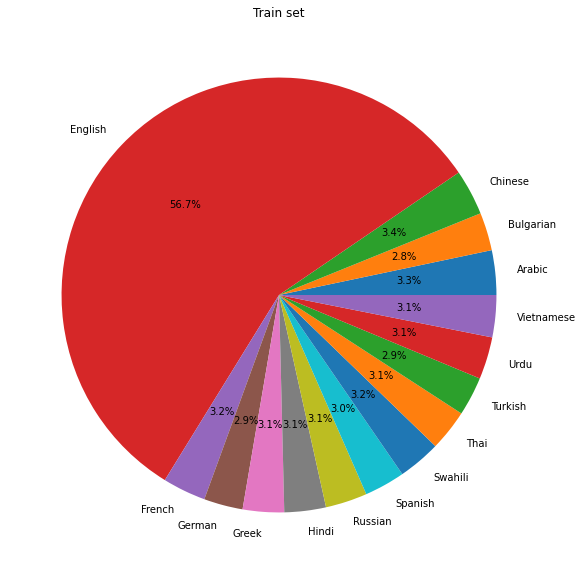

In [14]:
# Show the distribution of languages in the training set
labels, frequencies = np.unique(train.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.title("Train set")
plt.show()

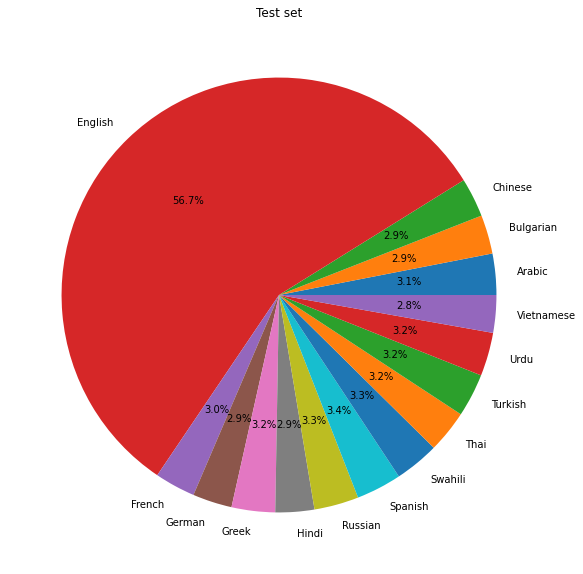

In [15]:
# Show the distribution of languages in the test set
labels, frequencies = np.unique(test.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.title("Test set")
plt.show()

### Used approaches

The following code is the first step for understanding these problems
- ###### My basic tokenizer

In [122]:
# First use my basic encoding approach
def basic_tokenizer(num_words, sentences):
    tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(sentences)
    
    return tokenizer

In [321]:
train_en = train[train.lang_abv == 'en'].iloc[:8000]
test_en = train[train.lang_abv == 'en']#.iloc[8000:]

In [322]:
t = Tokenizer(oov_token="<OOV>")
t.fit_on_texts(train_en.premise.values + train_en.hypothesis.values)
x_dict = t.word_index

display(len(x_dict))

13941

In [323]:
# My first basic model on english sentences
def first_model():
    max_sentence_length = 50
    pad_type = "post"
    trun_type = "post"
    # Create the tokenizer
    num_words = 8000
    tokenizer = basic_tokenizer(num_words, train_en.premise.values + train_en.hypothesis.values)
    
    
    # Tokenize the training data
    train_premise = tokenizer.texts_to_sequences(train_en.premise.values)
    train_hypothesis = tokenizer.texts_to_sequences(train_en.hypothesis.values)
    
    # Pad the training data
    train_pad_premise = pad_sequences(train_premise, maxlen=max_sentence_length, padding=pad_type, truncating=trun_type)
    train_pad_hypothesis = pad_sequences(train_hypothesis, maxlen=max_sentence_length, padding=pad_type, truncating=trun_type)

    # Define the layers
    model = tf.keras.Sequential(
        [
            tf.keras.Input((2*max_sentence_length,)),
            tf.keras.layers.Embedding(num_words, 9, input_length=2*max_sentence_length),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(120, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(3, activation='softmax'),
        ]
    )
    
    
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=["accuracy"],
    )
    
    concat_arrs_train = []
    
    for i in range(0, len(train_pad_premise)):
        concat_arrs_train.append(np.hstack((train_pad_premise[i], train_pad_hypothesis[i])))
            
    
    concat_arrs_train = np.array(concat_arrs_train)
    
    # Test the model
    # Tokenize the training data
    test_premise = tokenizer.texts_to_sequences(test_en.premise.values)
    test_hypothesis = tokenizer.texts_to_sequences(test_en.hypothesis.values)

    # Pad the training data
    test_pad_premise = pad_sequences(test_premise, maxlen=max_sentence_length, padding=pad_type, truncating=trun_type)
    test_pad_hypothesis = pad_sequences(test_hypothesis, maxlen=max_sentence_length, padding=pad_type, truncating=trun_type)
    
    concat_arrs_test = []
    
    for i in range(0, len(train_pad_premise)):
        concat_arrs_test.append(np.hstack((train_pad_premise[i], train_pad_hypothesis[i])))
    
    concat_arrs_test = np.array(concat_arrs_test)
    
    # Train and validate the nn
    model.fit(concat_arrs_train, train_en.label.values, epochs=30, validation_data=(concat_arrs_test, test_en.label.values))
    
    return model

In [324]:
display(basic_model.summary())
basic_model = first_model()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_88 (Embedding)    (None, 100, 9)            72000     
                                                                 
 flatten_5 (Flatten)         (None, 900)               0         
                                                                 
 dense_162 (Dense)           (None, 120)               108120    
                                                                 
 dense_163 (Dense)           (None, 64)                7744      
                                                                 
 dense_164 (Dense)           (None, 3)                 195       
                                                                 
Total params: 188,059
Trainable params: 188,059
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/30
215/215 [==============================] - 2s 6ms/step - loss: 1.0982 - accuracy: 0.3453 - val_loss: 1.0771 - val_accuracy: 0.4192
Epoch 2/30
215/215 [==============================] - 1s 5ms/step - loss: 1.0357 - accuracy: 0.4603 - val_loss: 0.8386 - val_accuracy: 0.6790
Epoch 3/30
215/215 [==============================] - 1s 5ms/step - loss: 0.7996 - accuracy: 0.6482 - val_loss: 0.5327 - val_accuracy: 0.8448
Epoch 4/30
215/215 [==============================] - 1s 5ms/step - loss: 0.4848 - accuracy: 0.8111 - val_loss: 0.2537 - val_accuracy: 0.9250
Epoch 5/30
215/215 [==============================] - 1s 5ms/step - loss: 0.2724 - accuracy: 0.9039 - val_loss: 0.1540 - val_accuracy: 0.9575
Epoch 6/30
215/215 [==============================] - 1s 5ms/step - loss: 0.1612 - accuracy: 0.9464 - val_loss: 0.0833 - val_accuracy: 0.9744
Epoch 7/30
215/215 [==============================] - 1s 5ms/step - loss: 0.1018 - accuracy: 0.9649 - val_loss: 0.0524 - val_accuracy: 0.9843
Epoch 

- ###### BERT approach

In [10]:
# Download the tokenizer
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
# The tokenizer is already learned, if I was about to
# build it by myself, I could also defina the prefix
# snowboarding -> snow, ##board, ##ing

In [11]:
# Tokenizer turns sequence of words into arrays of numbers
def encode_sentence(s):
    tokens = list(tokenizer.tokenize(s))
    # Initial token represented by 101 and final 102
    # This line adds the [sep] token to the end of sentence
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

In [12]:
print("[CLS] words, in, codes, [SEP]")
print("I love machine learning\n{}".format(encode_sentence("I love machine learning")))
print(tokenizer('I love machine learning'))
# Following lines shows the encoding of given words in bert
# token type has zeros and mask all 1s

[CLS] words, in, codes, [SEP]
I love machine learning
[146, 16138, 21432, 26901, 102]
{'input_ids': [101, 146, 16138, 21432, 26901, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}


In [32]:
# Bert uses three kinds of input data
# input word IDs, input masks, input type IDs

# These allows the model to know that the premise and 
# hypothesis are distinct sentences
# and also to ignore any padding from tokenizer

# We add a [CLS] token to denote the beginning of the inputs
# and a [SEP] token to denote the separation between the presmise
# and the hypothesis

# We also need to pad all of the inputs to be the same size

# Encoding all the premise/hypothesis into BERT

def bert_encode(hypotheses, premises, tokenizer, max_length=80):
    
    num_examples = len(hypotheses)
    
    # netsted encoded hypotheses
    sentence1 = tf.ragged.constant([
      encode_sentence(s)
      for s in np.array(hypotheses)])
    print(sentence1.shape)
    # nested encoded premises
    sentence2 = tf.ragged.constant([
       encode_sentence(s)
       for s in np.array(premises)])
    print(sentence2.shape)

    # sentense1.shape[0] of cls -> 101 for each sentence 1
    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
    # Concatenates tensors along one dimension
    input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)
    
    # Creates the same shape of array just with ones
    input_mask = tf.ones_like(input_word_ids).to_tensor()
    
    type_cls = tf.zeros_like(cls)
    type_s1 = tf.zeros_like(sentence1)
    type_s2 = tf.ones_like(sentence2)
    input_type_ids = tf.concat(
        [type_cls, type_s1, type_s2], axis=-1).to_tensor()

    inputs = {
        'input_word_ids': input_word_ids.to_tensor(),
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    }
    
    return inputs
    

In [33]:
train_input = bert_encode(train.premise.values, train.hypothesis.values, tokenizer)

(12120, None)
(12120, None)


In [24]:
lengths_p = train.premise.str.len()
lengths_h = train.hypothesis.str.len()
print("Max premise length:\n{}".format(lengths_p.max()))
print("Max hypothesis length:\n{}".format(lengths_h.max()))

print(train_input)

Max premise length:
967
Max hypothesis length:
276
{'input_word_ids': <tf.Tensor: shape=(12120, 259), dtype=int32, numpy=
array([[  101, 10111, 11762, ...,     0,     0,     0],
       [  101, 13252, 10301, ...,     0,     0,     0],
       [  101, 13810, 32181, ...,     0,     0,     0],
       ...,
       [  101, 10117, 12452, ...,     0,     0,     0],
       [  101, 11699, 10105, ...,     0,     0,     0],
       [  101, 11399, 14764, ...,     0,     0,     0]], dtype=int32)>, 'input_mask': <tf.Tensor: shape=(12120, 259), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>, 'input_type_ids': <tf.Tensor: shape=(12120, 259), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, .

Above we can see, there are three parts in the train_input

- input_words_ids 
    - encoded sentence, with tokens from both sides
    - all sentences are sized to same length and filled with 0
- input_mask
    - 1s where are the ids of sentence, 0s where not
- input_type_ids
    - filled with zeros

In this part of the notebook I'll focuss on the creation and the learning process of the models

I would also like to test different approaches to solving this problem

As first I will start with the basic ones and then gradually go to more advanced ones

In [15]:
# Maximal length of the layer
max_len = 50

def second_model():
    # Now I'll use the bert model
    # Bert is a stack of Transformer’s Encoder
    # Bert Base:  L=12, H=768,  A=12 -> 110M params
    # Bert Large: L=24, H=1024, A=16 -> 340M params
    bert_encoder = TFBertModel.from_pretrained(model_name)
    
    # Prepare the first layer of neural network
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    # Prepare the second layer of neural network
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    # Prepare the third layer of neural network
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    # Connect the vectors
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    # Create the output layer
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
    
    # Create the model
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    # Compile the model
    model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model
    

In [16]:
with strategy.scope():
    model = first_model()
    model.summary()

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 50)]         0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  177853440   ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_mask[0][0]',         

In [17]:
# Training of the model
model.fit(train_input, train.label.values, epochs = 1, verbose = 1, batch_size = 32, validation_split = 0.2)

ValueError: in user code:

    File "/home/dave/.local/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/home/dave/.local/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/dave/.local/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/home/dave/.local/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/home/dave/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/dave/.local/lib/python3.8/site-packages/keras/engine/input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 50), found shape=(32, 259)
